# Analysis 

In [1]:
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import sys
from glob import glob
#import h5py
import os
import contextlib

In [2]:
#from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
sys.path.append('../../algorithms')
import trainingvariables
import datatools
import helper
sys.path.append('../..')
#sys.path.append('/tools/Xilinx/Vivado/Vivado/2019.2/bin')

os.environ['PATH'] = os.environ['PATH'] + ':/tools/Xilinx/Vivado/Vivado/2019.2/bin'

import config
new_card='atlas_nsw_pad_z0'
#new_card=new_card + '_stg2BC'
#new_card=new_card + '_stg300um'
new_card=new_card + '_mm4BC'
DATA_LOC=config.DATA_LOC_VALIDATE
DATA_LOC=DATA_LOC.replace(config.CARD,new_card)
print("# WARNING: data path changed!!!!")
files=glob(f"{DATA_LOC}")
hls_report = {}
#norm is normalization for std, it is the std of the chi2 fit
from helper import plot_performance, conv_to_hls, compile_predict_profile
from helper import norm_a, norm_x, mult_fact, mult_facta

#norm_a = 0.43
#norm_x = 0.102
#mult_fact = 20
#mult_facta = 0.1167

# WARNING: data path changed!!!!


/srv/conda/envs/notebook/lib/python3.7/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [3]:
x_test_s = np.load(f'/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/hls4ml/X_test_50000_detMat_{new_card}.npy')
y_test_s = np.load(f'/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/hls4ml/Y_test_50000_detMat_{new_card}.npy')
x_true_s = y_test_s[:,0]*mult_fact
a_true_s = y_test_s[:,1]*mult_facta*1000

data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=20, sort_by='z')
data['ev_n_noise'] = data['ev_n_signals'] - data['ev_n_mu_signals']
detmat=config.DET
detmat=detmat.replace(config.CARD,new_card)
X_det = datatools.detector_matrix_2(dmat, sig_keys, detcard=detmat)
import linefit
lfits = linefit.get_fits(dmat, sig_keys)
print(" ")
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True)
lfits_theta = np.arctan(lfits[:,0])*1000
lfits_mu_theta = np.arctan(lfits_mu[:,0])*1000
this_cut=(Y_mu==1)

this_cut=(Y_mu==1) #delete from here
#int_bit = 7
#fra_bit = 15
#r = 5
#model_id = 2
#mod = models[model_id]['name']

#print(f"doing plots for {mod}")
mod_dir = "/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/"

#
X_prep = X_det
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1
x_test = X_prep[:,:,vars_of_interest]
x_test = x_test_s
x_true = data['ev_mu_x']
x_true = x_true_s
a_true = data['ev_mu_theta']*1000
a_true = a_true_s
#

#x_hls = np.load(f"{fld}/{models[model_id]['dir']}/reports/np_model_{int_bit+fra_bit}.{int_bit}_reuse_{r}_Latency_Static_BigTable_X.npy", allow_pickle=True)
#a_hls = np.load(f"{fld}/{models[model_id]['dir']}/reports/np_model_{int_bit+fra_bit}.{int_bit}_reuse_{r}_Latency_Static_BigTable_angle.npy", allow_pickle=True)
#x_hls = x_hls * mult_fact
#a_hls = a_hls *mult_facta*1000

  0%|          | 0/25000 [00:00<?, ?it/s]

~~ Reading data... ~~
~~ Calculating occupancy information... ~~


  0%|          | 0/25000 [00:00<?, ?it/s]

!!
I read 25000 events, of which 25000 have muon and 0 do not
!!
~~ Preparing detector-based data matrix ~~
Using detector card: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/cards/atlas_nsw_pad_z0_mm4BC.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 25000/25000 [00:02<00:00, 8677.26it/s]


Output data matrix shape: (25000, 20, 20)
 


In [4]:
###### x_test_s= []
fld = "/Data/ML/models/last"
conf_dicts = {}
models = []
models.append(
{'name': "large_model",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11",
'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run18",
'intbit': 10, 'lstyle': 'o-', 'fstyle': 'none',})

#models.append(
#{'name': "Medium_model",
#'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG",
#'intbit': 10, 'lstyle': 'o--', 'fstyle': 'none',})

models.append(
{'name': "Medium_model_run20",
'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run20",
'intbit': 12, 'lstyle': 'o--', 'fstyle': 'none',})

#models.append(
#{'name': "Small_model",
#'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run15",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "small_nobn",
#'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run22",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_l2",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run24",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_nobn",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run25",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_qkeras",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run29",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_qkeras_run30",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run30",
#'intbit': 10, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_qkeras_run32",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run34",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "large_qkeras_run33",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run34",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "large_qkeras_run35",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run35",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "large_qkeras_run35_nobn",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run35",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "large_run36_p50",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run36",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "medium_run36_p50",
#'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run36",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "medium_run37_p25",
'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED25_run37",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "medium_run37_p75",
#'dir': "MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED75_run37",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "large_run37_p25",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED25_run37",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "large_run37_p75",
#'dir': "MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED75_run37",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "med2_run38_p50",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run38_p50",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0'})
#models.append(
#{'name': "med2_run38",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run38",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run38",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run38",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "med2_run39",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "med3_run39",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20..4_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "med2_p50_run39",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "med3_p50_run39",
#'dir': "MyTCN_CL5.4.4.0..4.3.1.0_DL20..4_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "lar2_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "lar3_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20..4_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "lar2_p50_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "lar3_p50_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20..4_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "lar2_p70_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED70_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "lar3_p70_run39",
#'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20..4_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED70_run39",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "qlar2_run40",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run40",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "qlar2_nbn_run40",
#'dir': "QKeras.b16_QKeras.i2_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run40",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "qlar2_run41",
#'dir': "QKeras.b22_QKeras.i5_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run41",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "qlar2_nobn_run41",
#'dir': "QKeras.b22_QKeras.i5_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run41",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

#models.append(
#{'name': "qlar2_run42",
#'dir': "QKeras.b22_QKeras.i5_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run42",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
#models.append(
#{'name': "qlar2_run42_pruned",
#'dir': "QKeras.b22_QKeras.i5_MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED25_run42",
#'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

models.append(
{'name': "lar2_run43",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run43",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run43_pruned",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run43",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

models.append(
{'name': "lar2_run44",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run44",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run44_pruned",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run44",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

models.append(
{'name': "lar2_run45",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run45",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run45_pruned",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run45",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

models.append(
{'name': "lar2_run46",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run46",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run46_pruned",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run46",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})

models.append(
{'name': "lar2_run47",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run47",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})
models.append(
{'name': "lar2_run47_pruned",
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run47",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none',})


# plot performance for a model

In [5]:
len(a_true)

25000

In [6]:
lfits[this_cut][:,1].shape

(25000,)

In [7]:
(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].shape

(25000,)

In [8]:
(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].shape

(25000,)

In [9]:
(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)[:len(a_true)].shape

(25000,)

# convert to HLS

In [12]:
#model = keras.models.load_model(mod_dir+models[model_id]['dir'],compile=False)
#preds = model.predict(x_test)#, batch_size=1024)
#x_keras = preds[:,0]*mult_fact
#a_keras = preds[:,2]*mult_facta*1000

for i, model in enumerate(models):
    print(f"# INFO: model number:{i} is {model['name']}")
    qmodel = load_qmodel(mod_dir+model['dir'] + '/weights.h5',compile=False, custom_objects=co)
    hls_model = conv_to_hls(model, qmodel,default_precision="26,6",REWRITE_CONF=False, verbose=False,card=new_card)
    compile_predict_profile(model,hls_model,qmodel,x_test,x_true, a_true,REWRITE_RESULTS=False,card=new_card)

# INFO: model number:0 is large_model
precision: 26,6 model: MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run18
# INFO: Loading saved configuration of layers
Interpreting Model
Topology:
Layer name: inputs, layer type: InputLayer, input shapes: [[None, 20, 7]], output shape: [None, 20, 7]
Layer name: C1D_0, layer type: Conv1D, input shapes: [[None, 20, 7]], output shape: [None, 20, 7]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 20, 7]], output shape: [None, 20, 7]
Layer name: C1D_1, layer type: Conv1D, input shapes: [[None, 20, 7]], output shape: [None, 18, 5]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 18, 5]], output shape: [None, 18, 5]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 18, 5]], output shape: [None, 90]
Layer name: F_dense_0, layer type: Dense, input shapes: [[None, 

# plots

In [27]:

def plot_loss(history_dict, mod, card, save=False):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', color='red', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='blue', label='Validation loss')
    plt.title(f'Training and validation loss model {mod}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    if save:
        plt.savefig(f'model_plots/history_{mod}_{card}.pdf')
        plt.savefig(f'model_plots/history_{mod}_{card}.png')
    plt.show()

In [28]:
#for model in models:
#    plot_performance(model, ranges=[30,100],plot_residuals=False, PLOT_HLS = False, save=False)
for i, model in enumerate(models):
    print(f"# INFO: model number:is {model['name']}")
    plot_performance(model, plot_residuals=True, PLOT_HLS = True, save=True, card=new_card)

NameError: name 'models' is not defined

In [4]:
import warnings
warnings.filterwarnings("ignore")

import json
import pprint
import numpy as np
import six
import tempfile
import tensorflow.compat.v2 as tf
# V2 Behavior is necessary to use TF2 APIs before TF2 is default TF version internally.
tf.enable_v2_behavior()
from tensorflow.keras.optimizers import *

from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings

from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

print("using tensorflow", tf.__version__)
%matplotlib widget


using tensorflow 2.3.1


In [5]:
from qkeras.autoqkeras import AutoQKeras

!echo $PATH
!ls /tools/Xilinx/Vivado/Vivado/2019.2/bin

if True:
    hls_report[mod] = hls_model.build(csim=False)

In [20]:
hls_report = {}
for model in models:
    FILE_EXISTS = os.path.exists(mod_dir+model['dir'] + '/hls4ml_report.npy')
    if FILE_EXISTS:
        print(f"# INFO: loading saved report for model {model['name']}")
        hls_report[model['name']] = np.load(mod_dir+model['dir'] + '/hls4ml_report.npy',allow_pickle=True).item()
    else:
        print(f"# INFO: building hls project using vivado_hls for model {model['name']}")
        qmodel = load_qmodel(mod_dir+model['dir'] + '/weights.h5',compile=False, custom_objects=co)
        hls_model = conv_to_hls(model, qmodel,default_precision="26,6",REWRITE_CONF=False, verbose=False)
        hls_model.compile()
        hls_report[model['name']] = hls_model.build(csim=False)
        np.save(mod_dir+model['dir'] + '/hls4ml_report.npy',hls_report[model['name']] )
        

NameError: name 'models' is not defined

hls_report

In [18]:
print ("| key | keras perf. | hls perf. | Latency | Interval | DSP48E | LUT | BRAM |")
print ("|-----|-------------|-----------|---------|----------|--------|-----|------|")
print(f"| max_20 | ------------| --------- | 400     | 120      |{5520/20}|{663360/20}|{4320/20}|")
print(f"| max_16 | ------------| --------- | 400     | 120      |{5520/16}|{663360/16}|{4320/16}|")
print(f"| max_12 | ------------| --------- | 400     | 120      |{5520/12}|{663360/12}|{4320/12}|")
print(f"| max_08 | ------------| --------- | 400     | 45      |{5520/8}|{663360/8}|{4320/8}|")
for i, key in enumerate(hls_report.keys()):
    print (f"| {key} | {models[i]['x_std_keras']/norm_x:0.2f} , {models[i]['a_std_keras']/norm_a:0.2f} | \
        {models[i]['x_std_hls']/norm_x:0.2f} , {models[i]['a_std_hls']/norm_a:0.2f} | \
        {hls_report[key]['BestLatency']} | {hls_report[key]['IntervalMin']} | \
        {hls_report[key]['DSP48E']} | {hls_report[key]['LUT']} | {hls_report[key]['BRAM_18K']}|")

| key | keras perf. | hls perf. | Latency | Interval | DSP48E | LUT | BRAM |
|-----|-------------|-----------|---------|----------|--------|-----|------|
| max_20 | ------------| --------- | 400     | 120      |276.0|33168.0|216.0|
| max_16 | ------------| --------- | 400     | 120      |345.0|41460.0|270.0|
| max_12 | ------------| --------- | 400     | 120      |460.0|55280.0|360.0|
| max_08 | ------------| --------- | 400     | 45      |690.0|82920.0|540.0|
| large_model | 4.20 , 6.02 |         4.27 , 6.18 |         121 | 103 |         561 | 103373 | 28|
| Medium_model_run20 | 6.74 , 9.33 |         6.84 , 9.45 |         156 | 103 |         211 | 39768 | 0|
| medium_run37_p25 | 6.93 , 8.77 |         6.93 , 8.77 |         155 | 103 |         183 | 32167 | 0|
| lar2_run38_p50 | 6.18 , 7.17 |         6.18 , 7.17 |         55 | 42 |         628 | 44028 | 0|
| lar2_run38 | 5.67 , 7.33 |         5.66 , 7.34 |         55 | 42 |         1247 | 101366 | 0|
| lar2_run43 | 14.50 , 11.46 |      

In [19]:
print ("| key | keras perf. | hls perf. | Latency | Interval | DSP48E | LUT | BRAM |")
print ("|-----|-------------|-----------|---------|----------|--------|-----|------|")
print(f"| max_20 | ------------| --------- | 400     | 120      |{5520/20}|{663360/20}|{4320/20}|")
print(f"| max_16 | ------------| --------- | 400     | 120      |{5520/16}|{663360/16}|{4320/16}|")
print(f"| max_8 | ------------| --------- | 400     | 45      |{5520/8}|{663360/8}|{4320/8}|")
for i, key in enumerate(hls_report.keys()):
    print (f"| {key} | {models[i]['x_std_keras']/norm_x:0.2f} , {models[i]['a_std_keras']/norm_a:0.2f} | \
        {models[i]['x_std_hls']/norm_x:0.2f} , {models[i]['a_std_hls']/norm_a:0.2f} | \
        {hls_report[key]['BestLatency']} | {hls_report[key]['IntervalMin']} | \
        {hls_report[key]['DSP48E']} | {hls_report[key]['LUT']} | {hls_report[key]['BRAM_18K']}|")

| key | keras perf. | hls perf. | Latency | Interval | DSP48E | LUT | BRAM |
|-----|-------------|-----------|---------|----------|--------|-----|------|
| max_20 | ------------| --------- | 400     | 120      |276.0|33168.0|216.0|
| max_16 | ------------| --------- | 400     | 120      |345.0|41460.0|270.0|
| max_8 | ------------| --------- | 400     | 45      |690.0|82920.0|540.0|
| large_model | 4.20 , 6.02 |         4.27 , 6.18 |         121 | 103 |         561 | 103373 | 28|
| Medium_model_run20 | 6.74 , 9.33 |         6.84 , 9.45 |         156 | 103 |         211 | 39768 | 0|
| medium_run37_p25 | 6.93 , 8.77 |         6.93 , 8.77 |         155 | 103 |         183 | 32167 | 0|
| lar2_run38_p50 | 6.18 , 7.17 |         6.18 , 7.17 |         55 | 42 |         628 | 44028 | 0|
| lar2_run38 | 5.67 , 7.33 |         5.66 , 7.34 |         55 | 42 |         1247 | 101366 | 0|
| lar2_run43 | 14.50 , 11.46 |         14.50 , 11.46 |         55 | 42 |         1270 | 101697 | 0|
| lar2_run43_pr

hls_report

In [6]:
mods = []
mods.append(
{'name': "lar2_run38_p50", 'plot_name':'Nominal',
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0'})
mods.append(
{'name': "lar2_run45_pruned", 'plot_name':'stg2BC',
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run45",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_stg2BC'})
mods.append(
{'name': "lar2_run46_pruned", 'plot_name':'stg300um',
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run46",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_stg300um'})
mods.append(
{'name': "lar2_run47_pruned", 'plot_name':'mm4BC',
'dir': "MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run47",
'intbit': 3, 'lstyle': 'o:', 'fstyle': 'none','card':'atlas_nsw_pad_z0_mm4BC'})
cards={}
cards['Nominal'] = 'atlas_nsw_pad_z0'
cards['stg2BC'] = 'atlas_nsw_pad_z0_stg2BC'
cards['stg300um'] = 'atlas_nsw_pad_z0_stg300um'
cards['mm4BC'] = 'atlas_nsw_pad_z0_mm4BC'


In [29]:
results = {}
summary_x = {}
summary_a = {}
summary_mse_x = {}
summary_mse_a = {}
summary_percentil_x = {}
summary_percentil_a = {}
for model in mods:
    results[model['name']] = {}
    x_stds = []
    a_stds = []
    x_mses = []
    a_mses = []
    x_perc = []
    a_perc = []
    for card in cards.keys():
        json_file = mod_dir+model['dir'] + f'/hls4ml_results_{cards[card]}.npy'
        print('file: ' + json_file)
        FILE_EXISTS = os.path.exists(json_file)
        if FILE_EXISTS:
            print(f"# INFO: loading saved report for model {model['name']}")
            results[model['name']][card] = np.load(json_file,allow_pickle=True).item()
        else:
            print(f"# ERROR: report not found for model {model['name']} and card {cards[card]}")
        x_stds.append(results[model['name']][card]['x_std_hls']/norm_x)
        a_stds.append(results[model['name']][card]['a_std_hls']/norm_a)
        x_mses.append(results[model['name']][card]['x_mse_keras'])
        a_mses.append(results[model['name']][card]['a_mse_keras'])
        x_perc.append(results[model['name']][card]['x_percentil']/norm_x)
        a_perc.append(results[model['name']][card]['a_percentil']/norm_a)
    summary_x[model['plot_name']] = x_stds.copy()
    summary_a[model['plot_name']] = a_stds.copy()
    summary_mse_x[model['plot_name']] = x_mses.copy()
    summary_mse_a[model['plot_name']] = a_mses.copy()
    summary_percentil_x[model['plot_name']] = x_perc.copy()
    summary_percentil_a[model['plot_name']] = a_perc.copy()
    


file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38/hls4ml_results_atlas_nsw_pad_z0.npy
# INFO: loading saved report for model lar2_run38_p50
file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38/hls4ml_results_atlas_nsw_pad_z0_stg2BC.npy
# INFO: loading saved report for model lar2_run38_p50
file: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/algorithms/models/MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38/hls4ml_results_atlas_nsw_pad_z0_stg300um.npy
# INFO: loading sa

In [56]:
import seaborn as sns
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [111]:
#code from you.com
#data = summary_x
#labels = list(cards.keys())
colors = sns.color_palette('deep') #['red', 'green', 'blue', 'orange']

def diff_dataset_plot(data, labels, title, y_lim=[0,25]):
    x = np.arange(len(labels))  # the label locations
    width = 0.2 # the width of the bars

    fig, ax = plt.subplots(figsize=(10,8))
    rects = []

    for i, (key, values) in enumerate(data.items()):
        # draw the bars
        rects.append(ax.bar(x + i*width, values, width, label=key, color=colors[i]))


    # add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('std [units]', fontsize=20)
    ax.set_xlabel('Training Datasets', fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.legend()
    #ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    ax.set_ylim(y_lim)
    # modify legend properties
    legend = ax.legend(title='Test dataset', ncol=1, loc='upper right', fontsize=16)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1)
    legend.get_frame().set_alpha(1)
    legend.get_title().set_fontsize(18)

    # control the layout of the legend
    legend._legend_box.align = "center" 
    legend._set_loc(1)
    legend._set_loc((0.7, 0.7))


    def autolabel(rects):
        # function to attach a text label to each rectangl
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:0.1f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height), 
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=14)

    # add the value label
    for bar_group in rects:
        autolabel(bar_group)


    plt.savefig(f"model_plots/diff_dataset_results_{title.replace(' ','_')}.pdf")
    plt.show()

In [112]:
summary_x_transpose = {}
summary_a_transpose = {}
for i, key in enumerate(summary_x.keys()):
    summary_x_transpose[key] = [0,0,0,0]
    summary_a_transpose[key] = [0,0,0,0]
    for j, subkey in enumerate(summary_x.keys()):
        print (i, key, j, subkey )
        print (summary_x[subkey])
        summary_x_transpose[key][j] = summary_x[subkey][i].copy()
        summary_a_transpose[key][j] = summary_a[subkey][i].copy()

0 Nominal 0 Nominal
[5.852113386107575, 7.43423267550545, 6.177963545310293, 5.48892485582086]
0 Nominal 1 stg2BC
[19.006414602089283, 13.689734537375648, 18.708830363172087, 18.421974549265535]
0 Nominal 2 stg300um
[7.637447679687189, 9.091030416630502, 7.701183562057487, 7.70736736281422]
0 Nominal 3 mm4BC
[8.754782995656491, 10.22736560860936, 8.821312184332482, 8.905850671297356]
1 stg2BC 0 Nominal
[5.852113386107575, 7.43423267550545, 6.177963545310293, 5.48892485582086]
1 stg2BC 1 stg2BC
[19.006414602089283, 13.689734537375648, 18.708830363172087, 18.421974549265535]
1 stg2BC 2 stg300um
[7.637447679687189, 9.091030416630502, 7.701183562057487, 7.70736736281422]
1 stg2BC 3 mm4BC
[8.754782995656491, 10.22736560860936, 8.821312184332482, 8.905850671297356]
2 stg300um 0 Nominal
[5.852113386107575, 7.43423267550545, 6.177963545310293, 5.48892485582086]
2 stg300um 1 stg2BC
[19.006414602089283, 13.689734537375648, 18.708830363172087, 18.421974549265535]
2 stg300um 2 stg300um
[7.63744767

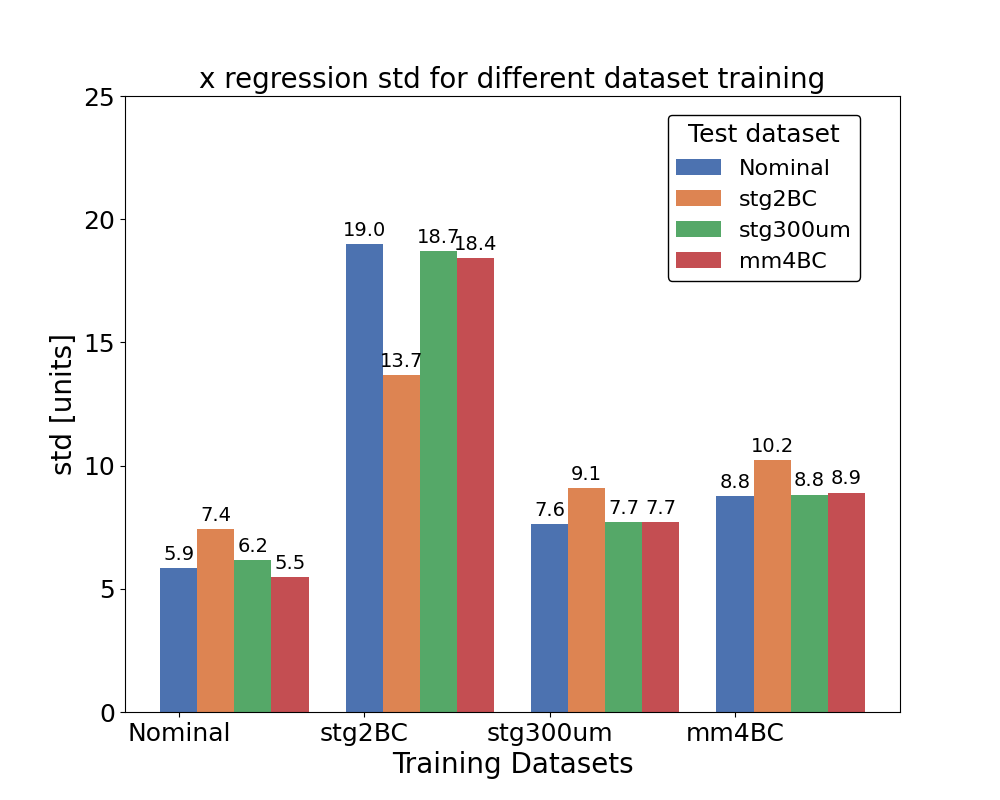

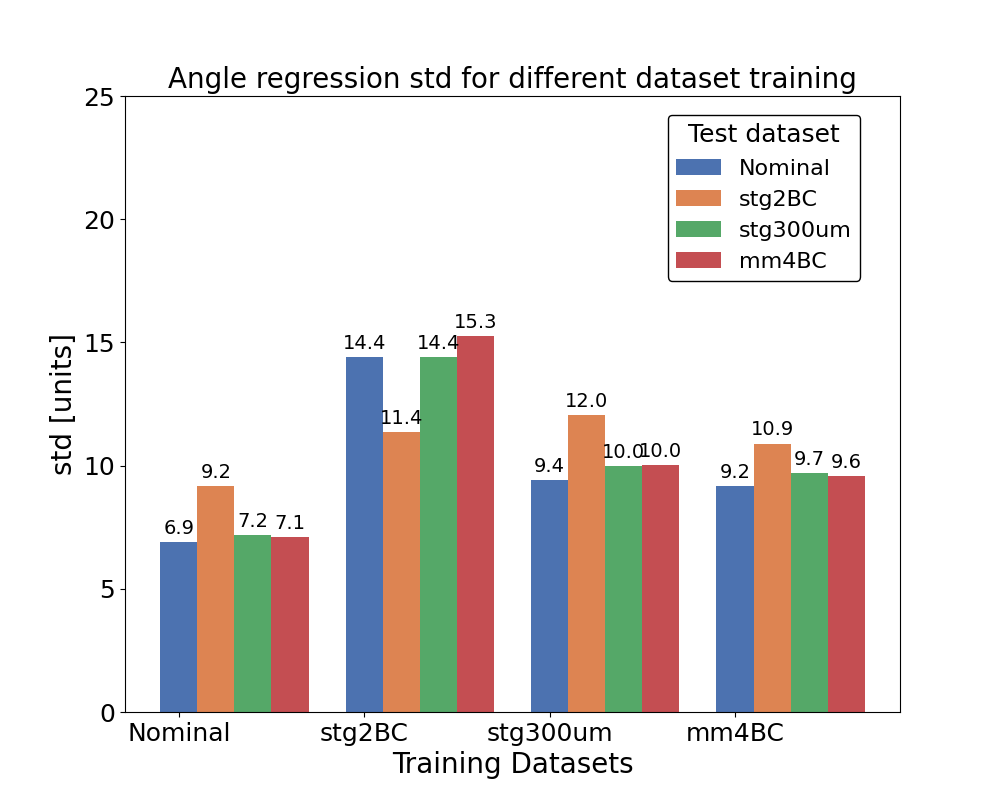

In [113]:
diff_dataset_plot(summary_x_transpose, list(cards.keys()), title='x regression std for different dataset training')
diff_dataset_plot(summary_a_transpose, list(cards.keys()), title='Angle regression std for different dataset training')

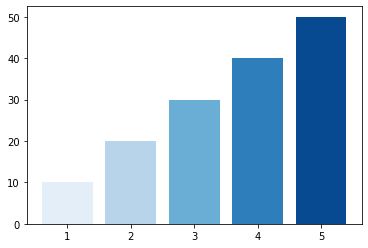

In [26]:
# Define a color scheme using the Blues palette
colors = plt.cm.Blues(np.linspace(0.1, 0.9, 5))

# Use the colors in your visualization
plt.bar([1, 2, 3, 4, 5], [10, 20, 30, 40, 50], color=colors)
plt.show()


### how to compute the quantile
q16, q84 = np.percentile(x, [16 ,84])
sigma = (q84 - q16)/2.

https://www.codecademy.com/learn/intro-statistics-numpy/modules/dspath-intro-statistics/cheatsheet

# regenerate


In [48]:
for model in mods:
    results[model['name']] = {}
    x_stds = []
    a_stds = []
    for card in cards.keys():
        x_test_s = np.load(f'/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/hls4ml/X_test_50000_detMat_{cards[card]}.npy')
        y_test_s = np.load(f'/afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/hls4ml/Y_test_50000_detMat_{cards[card]}.npy')
        x_true_s = y_test_s[:,0]*mult_fact
        a_true_s = y_test_s[:,1]*mult_facta*1000
        qmodel = load_qmodel(mod_dir+model['dir'] + '/weights.h5',compile=False, custom_objects=co)
        hls_model = conv_to_hls(model, qmodel,default_precision="26,6",REWRITE_CONF=False, verbose=False,card=cards[card])
        compile_predict_profile(model,hls_model,qmodel,x_test_s,x_true_s, a_true_s,REWRITE_RESULTS=True,card=cards[card])

model includes prunning, removing..
precision: 26,6 model: MyTCN_CL10.4.4.0..10.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run38
# INFO: Loading saved configuration of layers
Interpreting Model
Topology:
Layer name: inputs, layer type: InputLayer, input shapes: [[None, 20, 7]], output shape: [None, 20, 7]
Layer name: C1D_0, layer type: Conv1D, input shapes: [[None, 20, 7]], output shape: [None, 5, 10]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 5, 10]], output shape: [None, 5, 10]
Layer name: C1D_1, layer type: Conv1D, input shapes: [[None, 5, 10]], output shape: [None, 3, 10]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 3, 10]], output shape: [None, 3, 10]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 3, 10]], output shape: [None, 30]
Layer name: F_dense_0, layer type: Dense, input shapes: